In [1]:
https://towardsdatascience.com/hands-on-generative-adversarial-networks-gan-for-signal-processing-with-python-ff5b8d78bd28
%pip install tensorflow --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
from numpy import hstack
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense,LSTM
from matplotlib import pyplot
import matplotlib.pyplot as plt 

2023-03-21 17:34:20.823120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# https://stackoverflow.com/questions/68036975/valueerror-shape-must-be-at-least-rank-3-but-is-rank-2-for-node-biasadd
# config for rank error in lstm
tf.keras.backend.set_image_data_format("channels_last")

In [4]:
LENGTH_INPUT = 300

In [5]:
# define the standalone discriminator model
def define_discriminator(n_inputs=LENGTH_INPUT):
    model = Sequential()
    model.add(Dense(LENGTH_INPUT, activation='relu', input_dim=n_inputs))
    model.add(Dense(250, activation='relu', input_dim=n_inputs))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=LENGTH_INPUT):
    model = Sequential()
    model.add(Input(shape=(latent_dim, 1)))
    model.add(LSTM(150))
    model.add(Dense(LENGTH_INPUT, activation='linear'))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

    return model

In [7]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model


In [8]:
# generate n real samples with class labels
def generate_real_samples(n):
    amps = np.arange(0.1,10,0.1)
    bias = np.arange(0.1,10,0.1)
    freqs = np.linspace(1,2,1000)
    X2 = np.linspace(-5,5,LENGTH_INPUT)
    X1 = []
    for x in range(n):
        noise = np.random.normal(size=len(X2))
        X1.append(np.random.choice(amps)*np.sin(X2*np.random.choice(freqs))+np.random.choice(bias)+0.3*noise)
    X1 = np.array(X1).reshape(n, LENGTH_INPUT)
    # generate class labels
    y = ones((n, 1))
    return X1, y

In [9]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [10]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input, verbose=0)
    # create class labels
    y = zeros((n, 1))
    #print(x_input)
    return X, y

In [11]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=200):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            plt.title('Number of epochs = %i'%(i+1))
            pred_data = generate_fake_samples(generator,latent_dim,latent_dim)[0]
            real_data  = generate_real_samples(latent_dim)[0]
            plt.plot(pred_data[0],'.',label='Random Fake Sample',color='firebrick')
            plt.plot(real_data[0],'.',label = 'Random Real Sample',color='navy')
            plt.legend(fontsize=10)
            plt.show()

In [12]:
# size of the latent space
latent_dim = 3

In [13]:
# create the discriminator
discriminator = define_discriminator()

2023-03-21 17:34:22.760624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 17:34:22.766223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 17:34:22.767617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 17:34:22.769420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [14]:
# create the generator
generator = define_generator(latent_dim)

In [15]:
# create the gan
gan_model = define_gan(generator, discriminator)

2023-03-21 17:34:24.607984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda-11.0/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
2023-03-21 17:34:24.701871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-21 17:34:25.319212: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x56485d1035f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-21 17:34:25.319245: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-03-21 17:34:25.324013: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-21 17:34:25

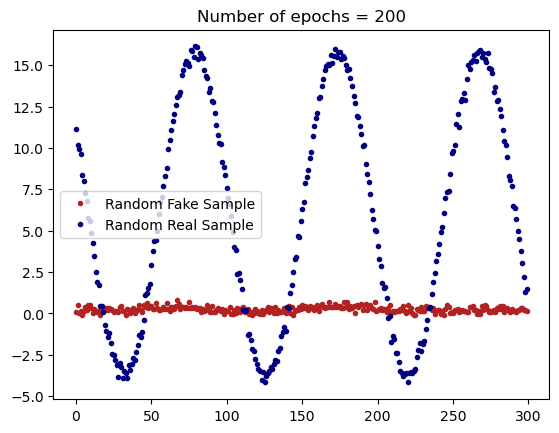

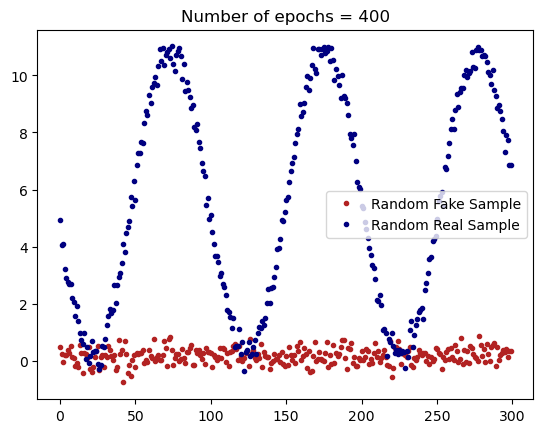

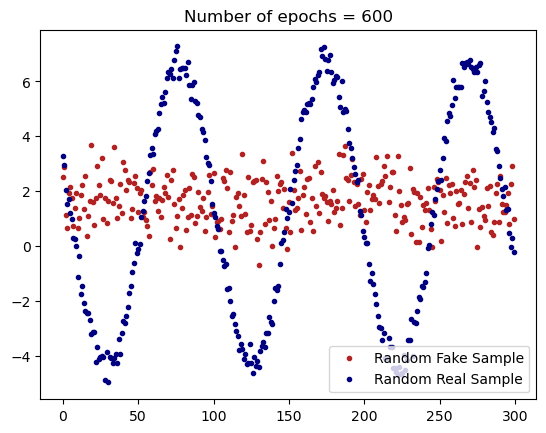

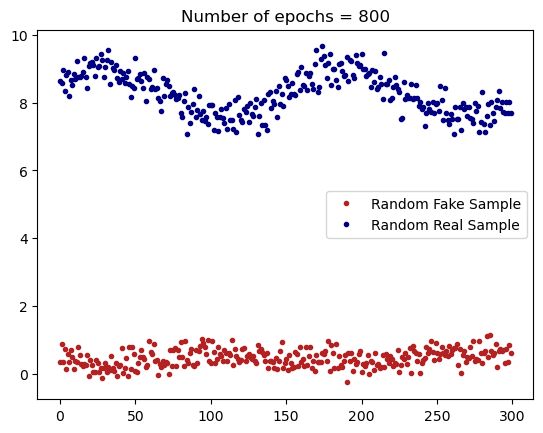

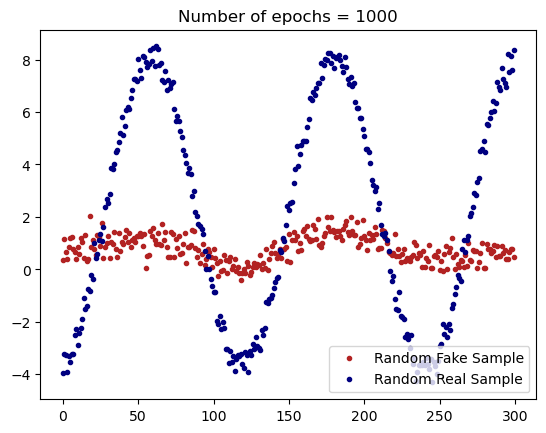

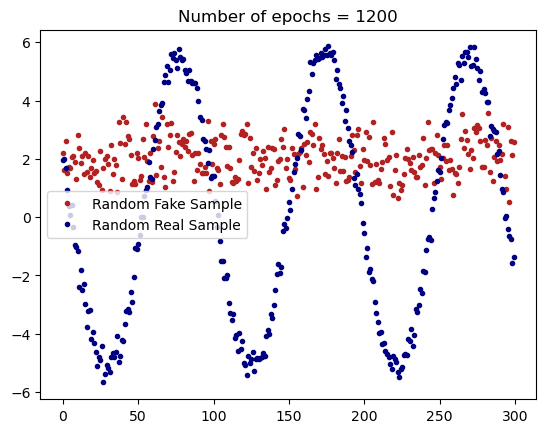

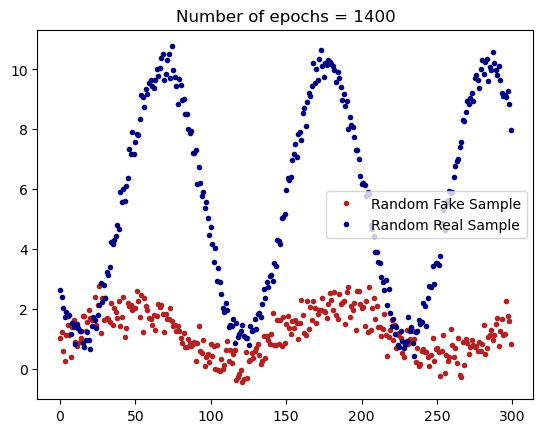

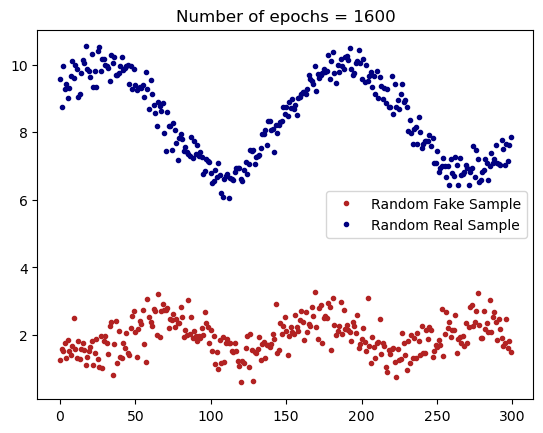

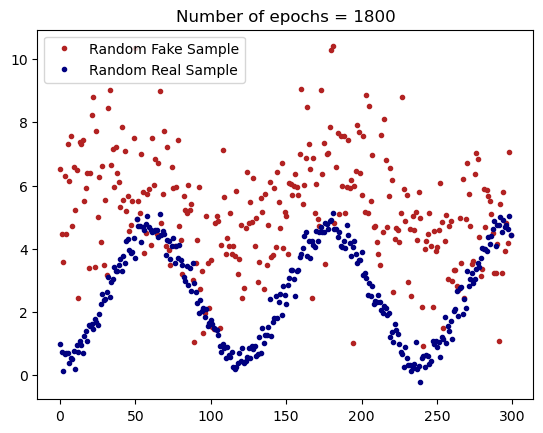

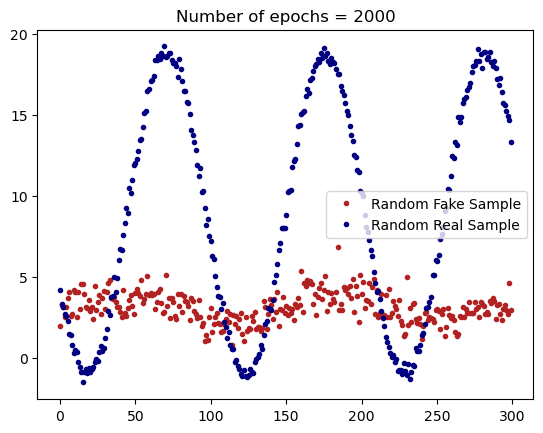

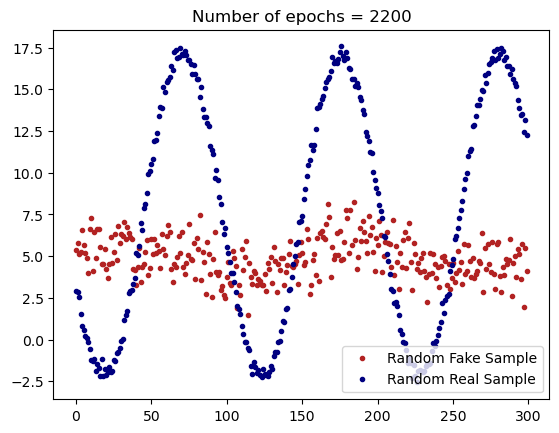

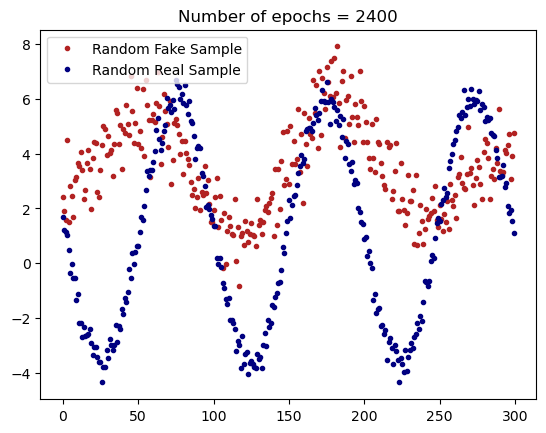

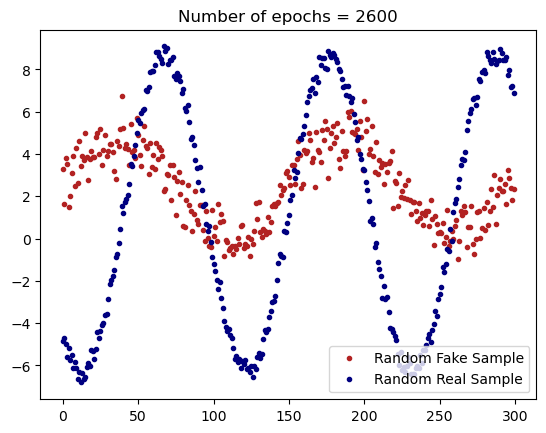

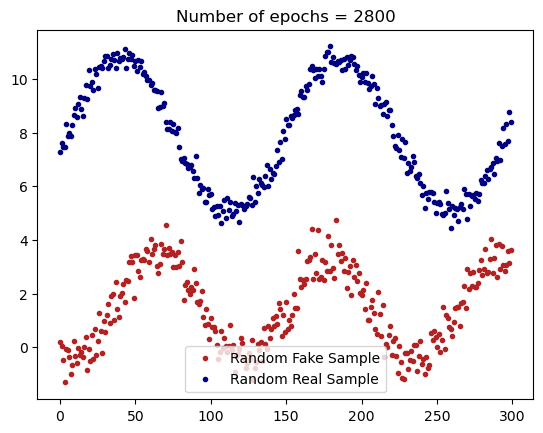

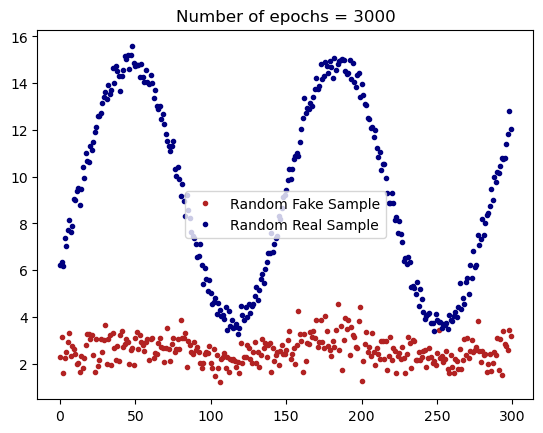

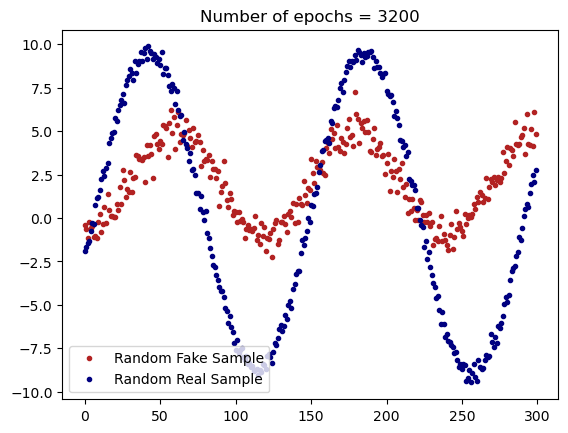

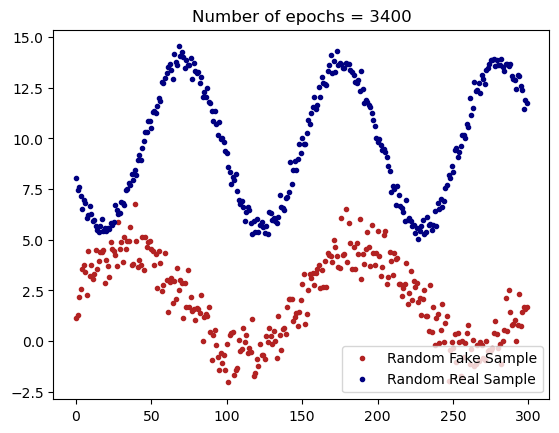

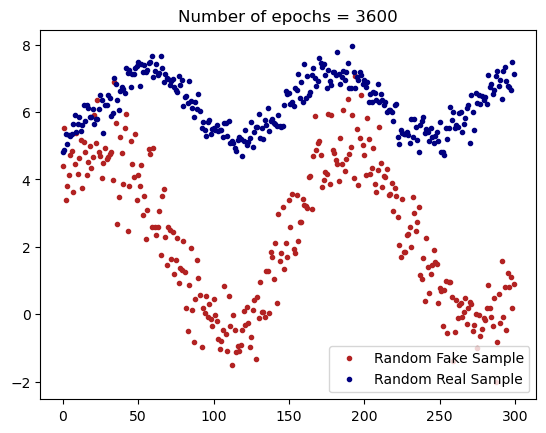

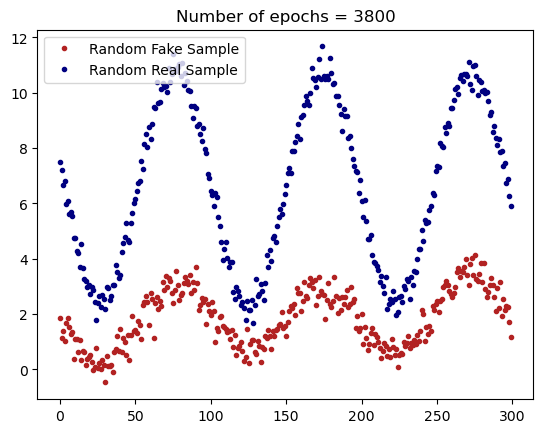

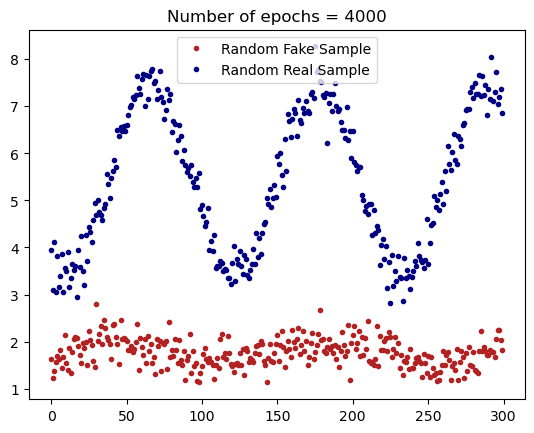

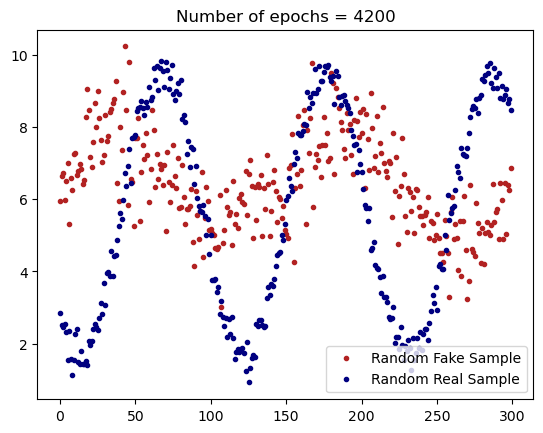

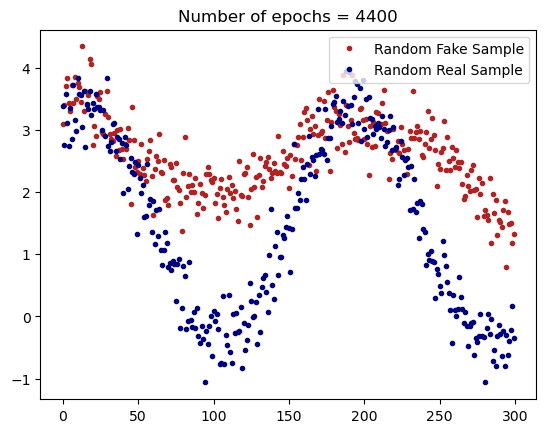

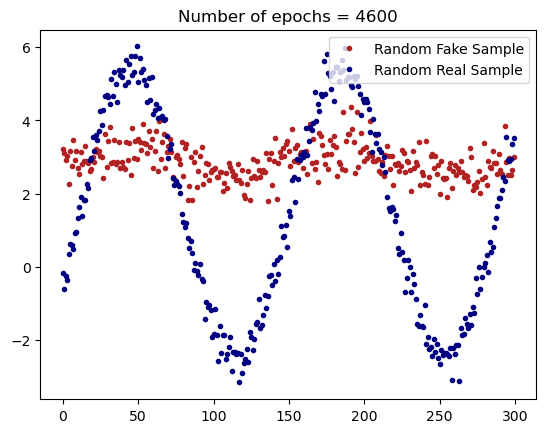

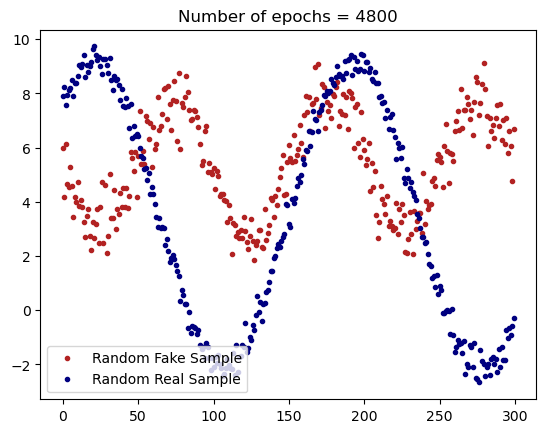

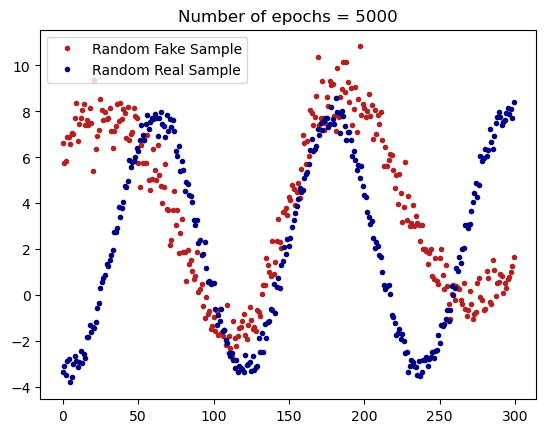

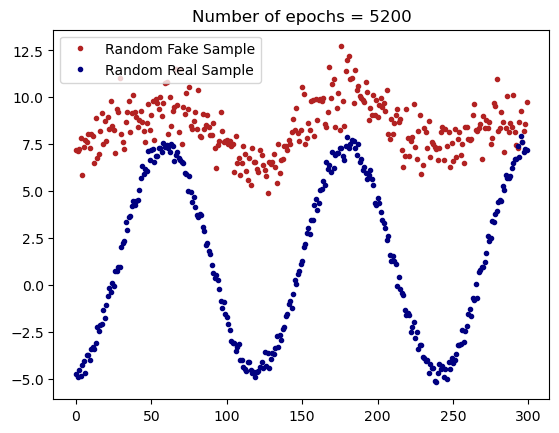

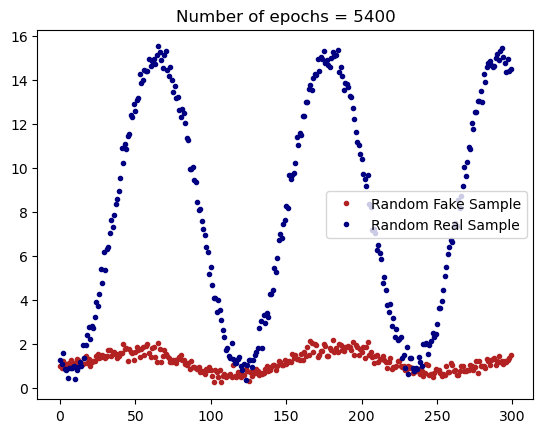

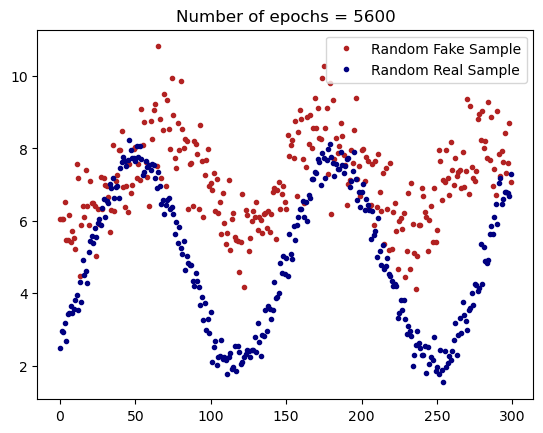

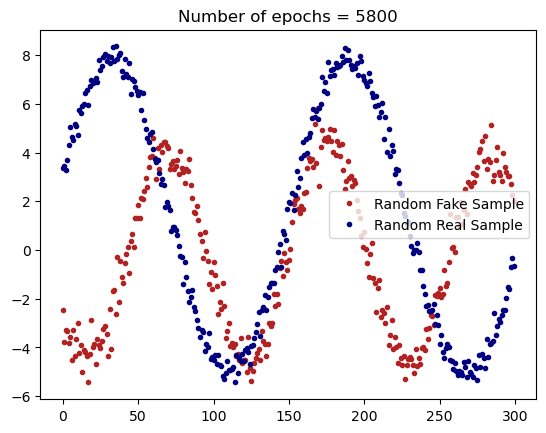

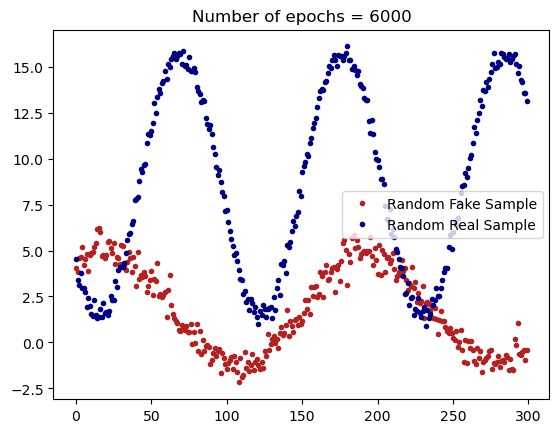

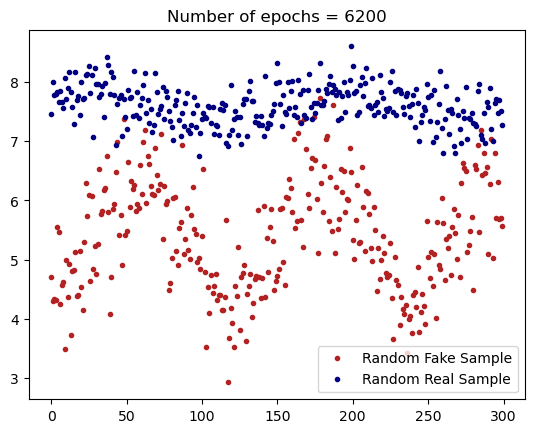

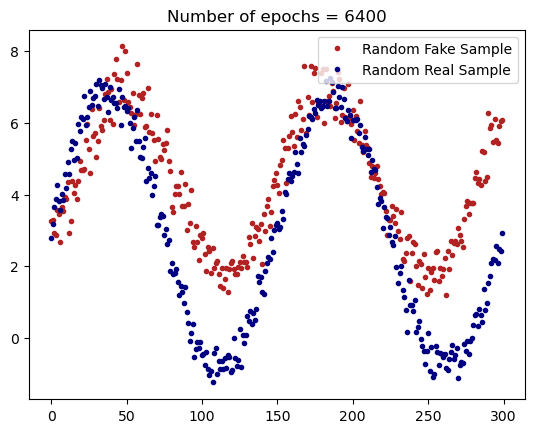

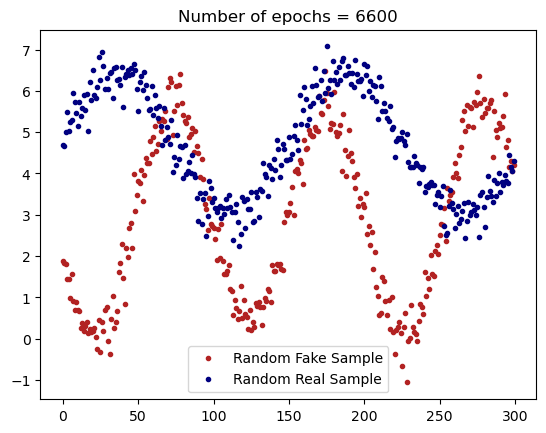

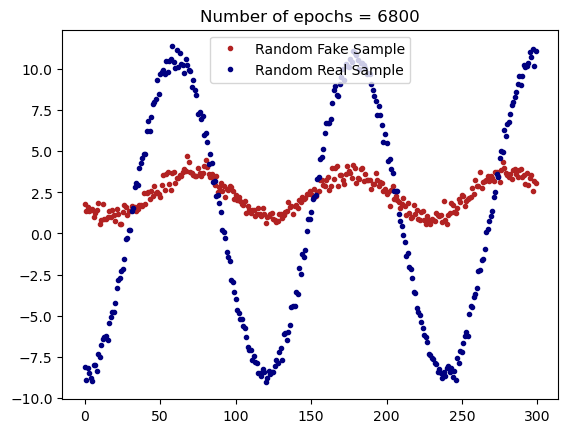

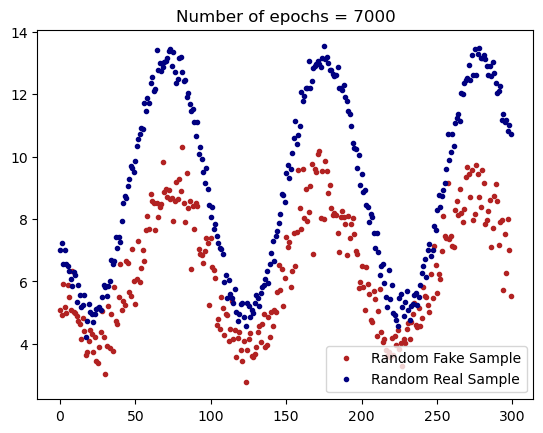

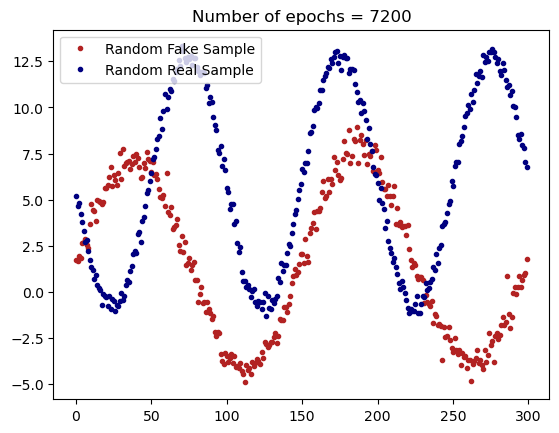

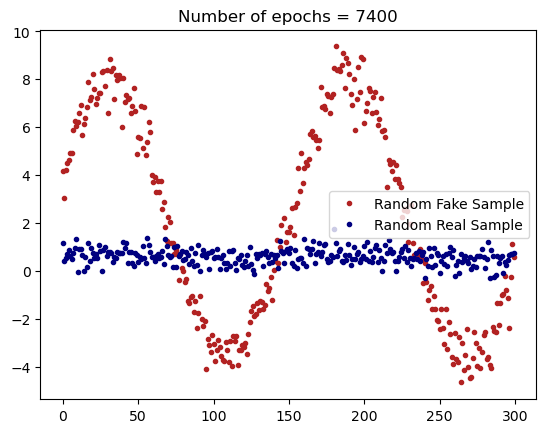

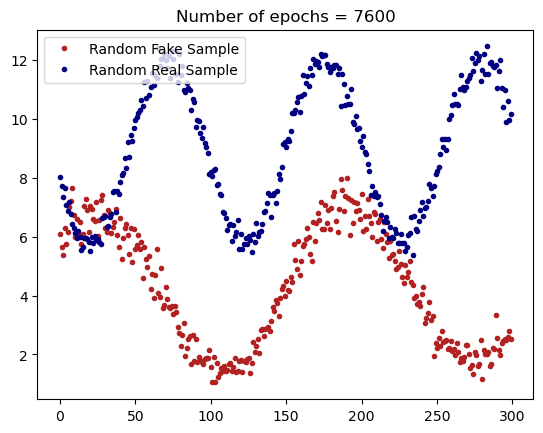

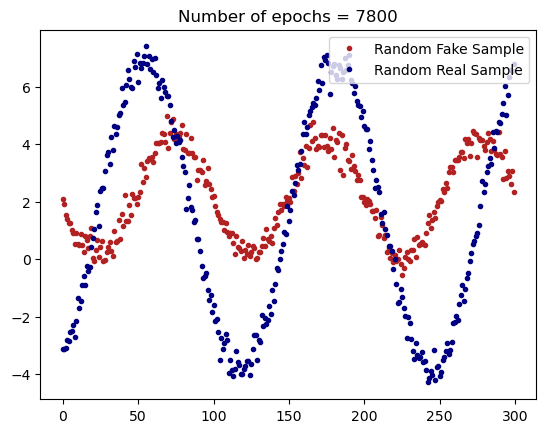

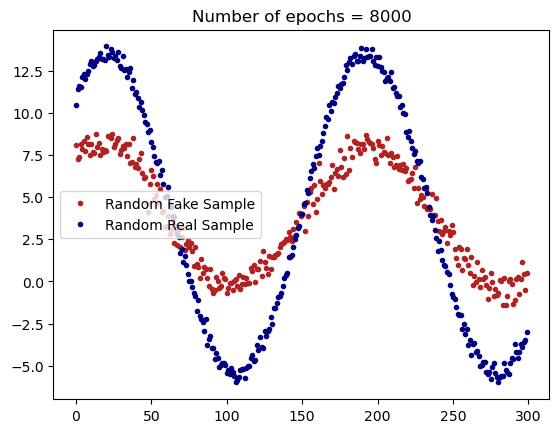

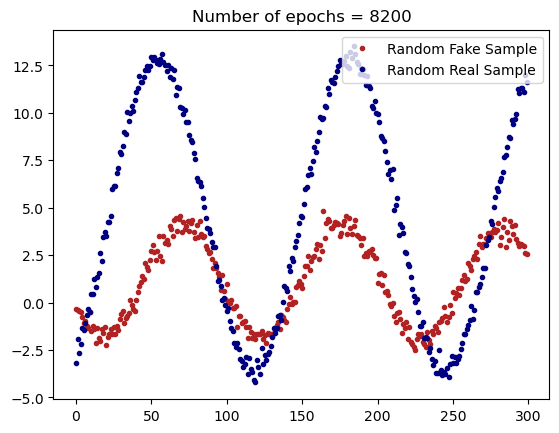

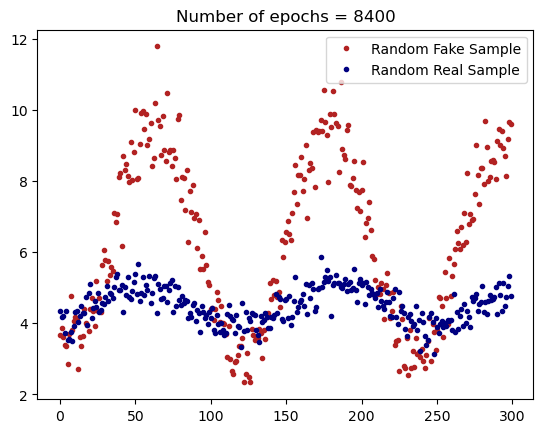

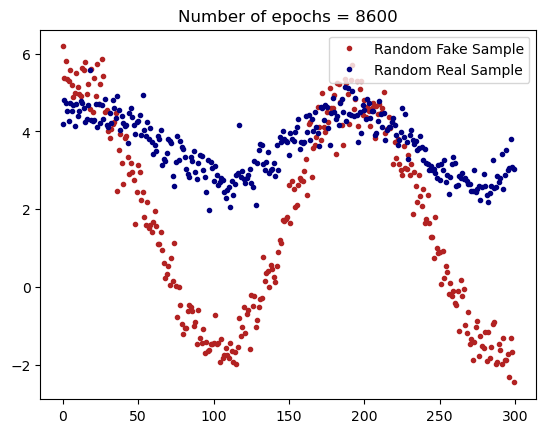

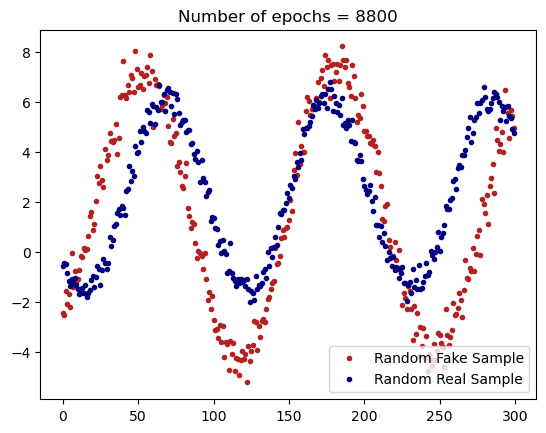

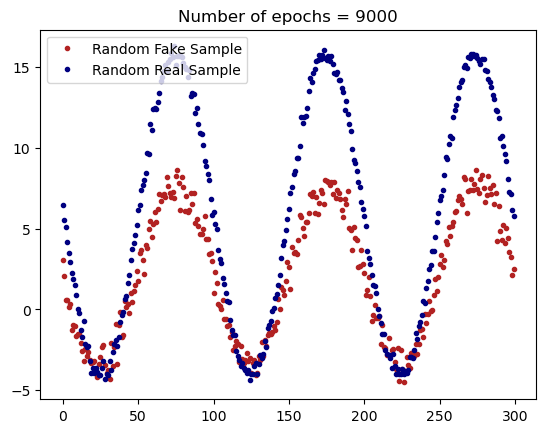

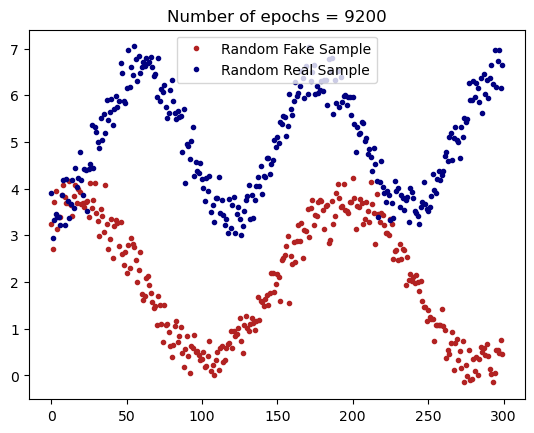

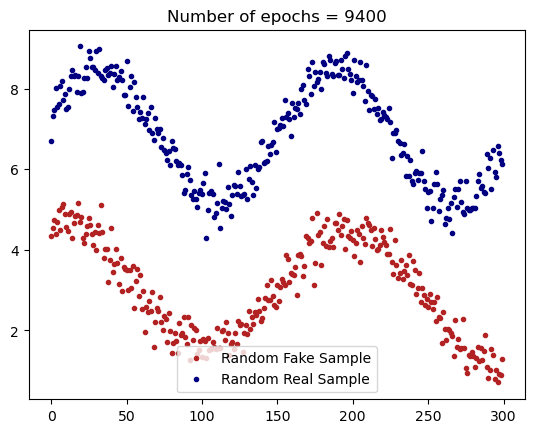

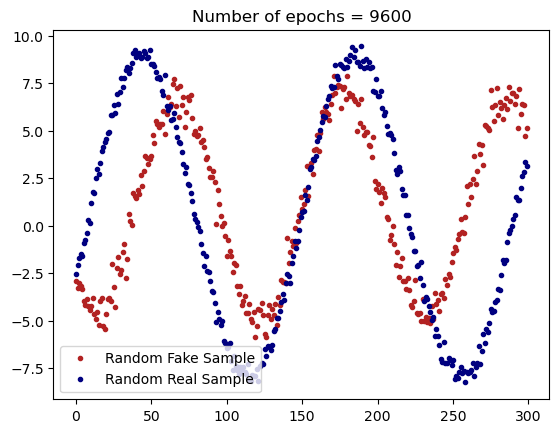

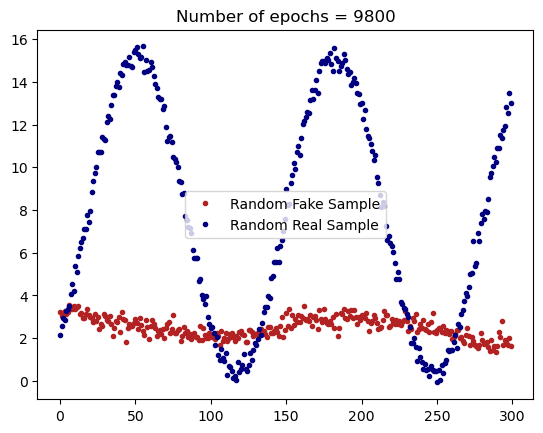

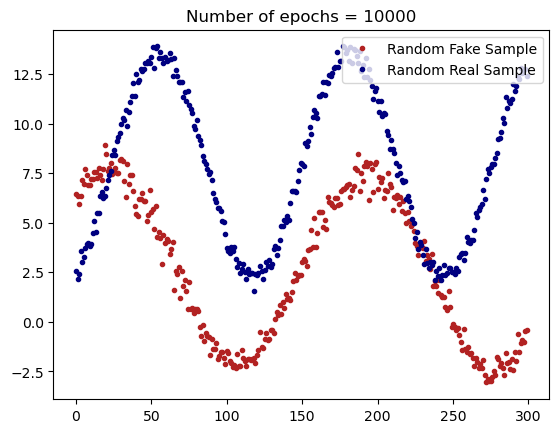

In [16]:
# train model
train(generator, discriminator, gan_model, latent_dim)

In [17]:
# Now let’s generate 100000 random signals.
pred_data = generate_fake_samples(generator,5,100000)[0]

In [18]:
# Now let’s generate 100k real signals.
real_data  = generate_real_samples(100000)[0]

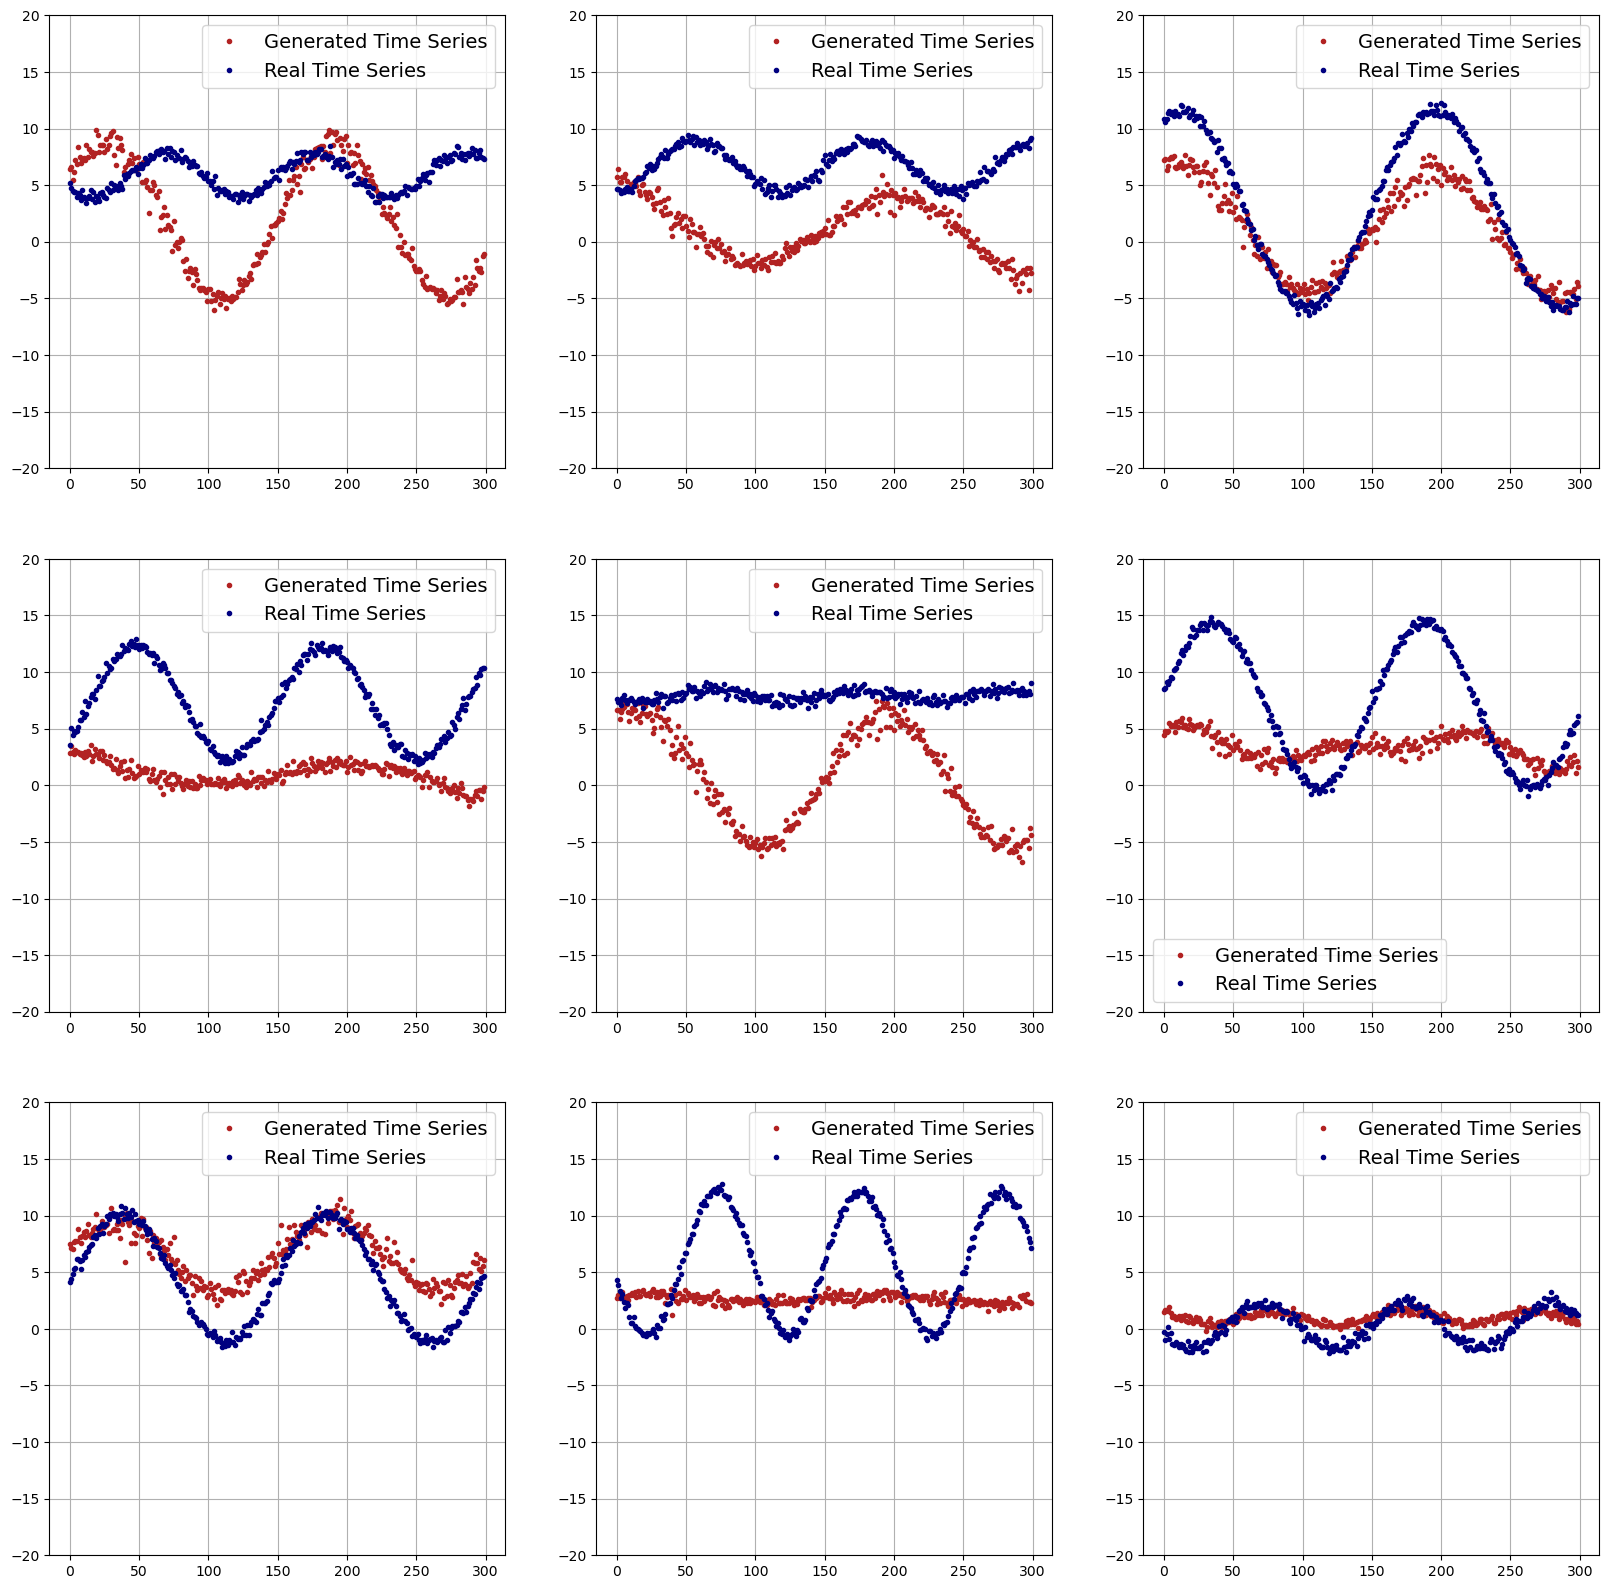

In [19]:
k=1
plt.figure(figsize=(20,20))
for i in range(9):
    plt.subplot(3,3,k)
    J = np.random.choice(np.random.choice(range(0,len(pred_data))))
    plt.plot(pred_data[J],'.',color='firebrick',label='Generated Time Series')
    plt.plot(real_data[J],'.',color='navy',label='Real Time Series')
    plt.legend(fontsize=14)
    plt.ylim(-20,20)
    plt.grid(True)
    k=k+1